# CoT Based Smart Web Search

- Author: [syshin0116](https://github.com/syshin0116)
- Design: 
- Peer Review: 
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/19-Cookbook/07-Agent/15-CoT-basedSmartWebSearch.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/19-Cookbook/07-Agent/15-CoT-basedSmartWebSearch.ipynb)

## Overview

This tutorial demonstrates a chain-of-thought (CoT) based smart web search approach designed to build a plan-and-execute style QA chatbot. The system breaks down complex user queries into a sequence of actionable steps such as **search**, **extraction**, **reasoning**, and **response generation**. It leverages language models to perform each task, ensuring that every phase of the process is handled efficiently and accurately.

Throughout the tutorial, you will learn how to set up your environment, install the necessary packages, and define key data models using `Pydantic`. These models enforce a structured workflow by representing each task step (e.g., **search**, **think**, and **respond**) and by specifying how references and final outputs should be formatted in markdown.

The workflow is composed of multiple nodes, each responsible for a specific phase of the processing pipeline. You will see how the system generates a plan from a user query, retrieves raw information from the web, extracts and summarizes the relevant data, optionally refines the results through additional reasoning, and finally compiles a comprehensive answer. The nodes are dynamically connected through a routing function that adapts to the current state of the process.

A key aspect of this tutorial is the integration of asynchronous execution, which allows the entire workflow to run in real time. This not only improves performance but also provides immediate feedback during long-running tasks, making it easier to monitor and debug the process.

### Key Features

- **Chain-of-Thought Query Expansion**: Breaks down complex queries into manageable steps.
- **Modular Workflow**: Separates the process into distinct nodes for planning, searching, extracting, reasoning, and responding.
- **Asynchronous Execution**: Enables real-time streaming and monitoring of the workflow.
- **Dynamic Task Routing**: Adapts the processing sequence based on the current state, ensuring efficient task handling.
- **Robust Data Modeling**: Uses `Pydantic` to enforce data consistency and type safety throughout the system.
### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [Data Models and Type Definitions](#data-models-and-type-definitions)
- [Define Nodes for the Workflow](#define-nodes-for-the-workflow)
- [Route Tasks and Compile Workflow](#route-tasks-and-compile-workflow)
- [Run Workflow](#run-workflow)

### References

- [Language Agent Tree Search Unifies Reasoning Acting and Planning in Language Models](https://arxiv.org/abs/2310.04406)
- [Building (and Breaking) WebLangChain](https://blog.langchain.dev/weblangchain/)
- [Plan-and-Execute Agents](https://blog.langchain.dev/planning-agents/)
- [CopilotKit](https://github.com/CopilotKit/CopilotKit)
----

## Environment Setup

Setting up your environment is the first step. See the [Environment Setup](https://wikidocs.net/257836) guide for more details.


**[Note]**

The langchain-opentutorial is a package of easy-to-use environment setup guidance, useful functions and utilities for tutorials.
Check out the  [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [1]:
%%capture --no-stderr
%pip install langchain-opentutorial

# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langsmith",
        "langchain",
        "langchain_core",
        "langchain-anthropic",
        "langchain_community",
        "langchain_text_splitters",
        "langchain_openai",
    ],
    verbose=False,
    upgrade=False,
)

In [2]:
# Install required packages
from langchain_opentutorial import package

package.install(
    ["duckduckgo-search"],
    verbose=False,
    upgrade=False,
)


[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [3]:
# Set environment variables
from langchain_opentutorial import set_env

set_env(
    {
        "OPENAI_API_KEY": "",
        "LANGCHAIN_API_KEY": "",
        "LANGCHAIN_TRACING_V2": "true",
        "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
        "LANGCHAIN_PROJECT": "COT-based-smart-websearch",
        "TAVILY_API_KEY": "",
    }
)

Environment variables have been set successfully.


You can alternatively set API keys such as `OPENAI_API_KEY` in a `.env` file and load them.

[Note] This is not necessary if you've already set the required API keys in previous steps.

In [4]:
# Load API keys from .env file
from dotenv import load_dotenv

load_dotenv(override=True)

True

In [5]:
# import for asynchronous tasks
import asyncio
import nest_asyncio

nest_asyncio.apply()

## Data Models and Type Definitions

This section lays the foundation for the entire tutorial by defining the key data structures using `Pydantic`. 

It provides clear models for representing each step in the research process (i.e., **search**, **think**, and **respond**), as well as the structure of references and the final markdown response. 

Using these models ensures data consistency and type safety throughout the workflow.

In [6]:
from pydantic import BaseModel, Field
from typing import Literal
from langchain.tools import tool
from typing import List, Optional, Annotated
from langgraph.graph import MessagesState
import operator
from typing_extensions import TypedDict
from pprint import pprint


class TaskStep(BaseModel):
    """
    Model for a task step in the research process
    Types:
      - "search": Retrieve raw information from the web
      - "think": (Optional) Further analyze or refine extracted data from search
      - "respond": Generate the final answer
    """

    id: str = Field(description="Unique identifier for the step")
    description: str = Field(
        description='Step description, e.g., "Search for latest AI news"'
    )
    status: Literal["pending", "in_progress", "completed"] = Field(
        description='Step status: "pending", "in_progress", or "completed"'
    )
    type: Literal["search", "think", "respond"] = Field(
        description='Step type: "search", "think", or "respond"'
    )
    data: dict = Field(default_factory=dict, description="Additional data for the step")
    search_result: Optional[List] = Field(description="The search result")
    result: Optional[List] = Field(description="The result of the step")


class TaskSteps(BaseModel):
    """
    Model for a list of task steps
    """

    steps: List[TaskStep] = Field(description="List of task steps")


class Reference(BaseModel):
    """
    Schema for a reference
    """

    citation_id: int = Field(description="The citation id starting from 1")
    title: str = Field(description="The title of the reference")
    url: str = Field(description="The url of the reference")


class FinalResponse(BaseModel):
    """
    Schema for the final response
    """

    markdown: str = Field(
        description="The markdown formatted final response with inline citations. If you add any headings, make sure to start at level (##)"
    )
    references: list[Reference] = Field(description="A list of references")

### Define Agent and Worker State

In this part, two distinct state models are defined: one for the overall agent and one for individual worker tasks.

The **agent state** encapsulates the full progress of the system, including all processing steps, search results, and the final answer.

The **worker state** focuses on managing the current task being executed.

This separation enhances modularity and simplifies debugging and maintenance.

In [7]:
class AgentState(MessagesState):
    """
    The state of the agent.
    Contains the model identifier, a list of steps, and the final answer.
    """

    steps: Annotated[list, operator.add]
    search_result: Annotated[str, operator.add]
    extraction_result: Optional[str]
    think_result: Optional[str]
    answer: Optional[str]


class WorkerState(TypedDict):
    steps: Annotated[list, operator.add]
    current_step: TaskStep

### Initialize Chat Models
This header covers the initialization of the language models that drive the workflow.

Two chat models are set up: one optimized for **smart processing** (using enhanced reasoning capabilities) and another for **fast execution** (for tasks requiring quicker responses).

This dual-model approach allows the system to balance quality and speed depending on the task at hand.

In [8]:
from langchain_openai import ChatOpenAI

smart_model = ChatOpenAI(model="gpt-4o", temperature=0.5)
fast_model = ChatOpenAI(model="gpt-4o-mini", temperature=0.5)

## Define Nodes for the Workflow
This section explains how the workflow is decomposed into discrete, manageable nodes.

Each node represents a specific phase in processing the user query—from planning steps, fetching information, refining data, to generating the final answer.

This modular design simplifies both debugging and future enhancements.

### Plan Steps Node
The **plan steps node** is the entry point of the workflow.

It takes the user's query and generates a structured plan outlining the necessary steps to answer it.

These steps include creating search tasks, optional think tasks for deeper analysis, and a final respond task to craft the answer.

A well-defined plan here is crucial for effective execution in later nodes.

In [9]:
from datetime import datetime
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables import RunnableConfig


async def plan_steps_node(state: AgentState, config: RunnableConfig):
    """
    Generate a plan of steps for the research process.
    The plan should include steps of type "search", and "respond".
    Optionally, a "think" step may be included if further analysis is desired.
    """
    instructions = f"""
You are an assistant specialized in breaking down complex queries into actionable steps.

Generate a plan of steps to find the answer to the user's query.
If the query is simple, you may directly create one "respond" step.

Divide the query into the following steps:
- First, create one or more "search" steps to retrieve raw information from the web.
- Optionally, create a "think" step to analyze the extracted data further.
- Finally, create a "respond" step to generate the final answer in markdown format.

Current date: {datetime.now().strftime("%Y-%m-%d")}.
"""
    response = await smart_model.with_structured_output(TaskSteps).ainvoke(
        [
            SystemMessage(content=instructions),
            HumanMessage(
                content=state["messages"][0].content,
            ),
        ],
        config,
    )

    return {"steps": response.steps}

### Search Node
In the **search node**, the system actively retrieves information from the web.

It generates multiple search queries based on the current task description and invokes an external search tool (i.e., `TavilySearchResults`).

This node gathers the raw data needed for subsequent processing and updates the task state accordingly.

In [10]:
import json
import asyncio
from datetime import datetime
from langchain_community.tools import TavilySearchResults
from langchain_core.messages import SystemMessage, HumanMessage


async def search_node(state: WorkerState, config: RunnableConfig):
    """
    Execute a pending "search" step.
    This node generates multiple search queries for the current step and then invokes
    the Tavily search tool for each query. The results are aggregated and stored in the current step's data.
    """

    # Initialize the Tavily search tool
    tavily_tool = TavilySearchResults(
        max_results=3,
        search_depth="advanced",
        include_answer=True,
        include_raw_content=True,
        include_images=False,
    )

    # Retrieve the steps list and current step from WorkerState
    steps_list = state.get("steps", [])
    current_step = state.get("current_step")
    if current_step is None:
        raise ValueError("No pending search step found in WorkerState.")

    # Prepare system and human instructions for generating multiple queries
    system_instructions = f"""
You are an AI assistant specialized in generating search queries.
Based on the following step description, generate multiple relevant search queries.
Current date: {datetime.now().strftime("%Y-%m-%d")}.
"""
    human_instructions = f"Current step: {current_step.description}"

    # Bind the search tool to the model and invoke it with the messages
    model = smart_model.bind_tools([tavily_tool], tool_choice=tavily_tool.name)
    response = await model.ainvoke(
        [
            SystemMessage(content=system_instructions),
            HumanMessage(content=human_instructions),
        ],
        config,
    )

    tool_msg = await tavily_tool.ainvoke(response.tool_calls[0])
    current_step.status = "completed"

    return {"search_result": tool_msg.content}

### Extraction Node

Once the raw data is collected, the **extraction node** processes this information by summarizing and highlighting the most relevant details.

It extracts key data points and reference links while formatting the output in markdown.

This focused summarization reduces noise and improves the quality of the final answer.

In [11]:
async def extraction_node(state: AgentState, config: RunnableConfig):
    """
    Extract and summarize key information from raw search results.
    This node should run immediately after a search step.
    """

    raw_search_results = state["search_result"]
    system_instructions = f"""
You are an assistant that summarizes raw search results.
Please extract and summarize the relevant information, including key data and reference links.
DO NOT INCLUDE ANY EXTRA INFORMATION. ALL OF THE INFORMATION YOU ARE LOOKING FOR IS IN THE SEARCH RESULTS.
DO NOT answer the user's query yet. Just summarize the search results.

Use markdown formatting and put the references inline and the links at the end.
Like this:
This is a sentence with a reference to a source[1] and another reference[2].
[1]: [Title of Source 1](http://example.com/source1)
[2]: [Title of Source 2](http://example.com/source2)
"""
    human_instructions = f"Raw search results: {raw_search_results}"
    response = await fast_model.ainvoke(
        [
            state["messages"][0].content,
            SystemMessage(content=system_instructions),
            HumanMessage(content=human_instructions),
        ],
        config,
    )

    return {"extracton_result": response.content}

### Think Node
The **think node** provides an optional but valuable reasoning phase.

If further analysis is required, this node refines and reorganizes the extracted data to enhance clarity and detail.

It acts as an intermediary step to bridge the gap between raw information and a coherent final answer.

In [12]:
async def think_node(state: AgentState, config: RunnableConfig):
    """
    Optionally process the extracted information for further analysis.
    This node is executed if there is a pending "think" step.
    """
    steps_list = state.get("steps", [])
    current_step = next(
        (
            step
            for step in steps_list
            if step.status == "pending" and step.type == "think"
        ),
        None,
    )

    print(current_step)

    # System and Human Instructions
    system_instructions = """
You are an advanced reasoning AI designed to analyze and refine information.
Carefully evaluate the provided data to enhance its clarity and completeness.
"""

    human_instructions = f"""
Based on the following extracted data:
{steps_list}
Please analyze and refine the information before generating the final answer.
"""

    response = await fast_model.ainvoke(
        [
            SystemMessage(content=system_instructions),
            HumanMessage(content=human_instructions),
        ],
        config,
    )

    # Update the current step using dictionary assignment
    current_step.status = "completed"
    return {"think_result": response.content}

### Response Node

The **response node** aggregates all processed information from previous steps to generate the final answer.

It formats the response in markdown, including inline citations and links, ensuring the output is clear and well-referenced.

In [13]:
import json
from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableConfig
from langchain.tools import tool
from pydantic import BaseModel, Field


async def response_node(state: AgentState, config: RunnableConfig):
    """
    Generate the final answer using the aggregated information.
    """

    system_message = f"""
Based on the following steps to answer the user's query, generate a clear and concise final answer in markdown format.

All steps:
{state["steps"]}

Put the references inline and the links at the end.

Like this:
This is a sentence with a reference to a source[1] and another reference[2].
[1]: [Title of Source 1](http://example.com/source1)
[2]: [Title of Source 2](http://example.com/source2)
"""

    response = await smart_model.with_structured_output(FinalResponse).ainvoke(
        [
            state["messages"][0].content,
            HumanMessage(content=system_message),
        ],
        config,
    )

    return {"answer": response}

## Route Tasks and Compile Workflow

This section describes how tasks are dynamically routed between nodes based on the current state.

It explains the logic behind selecting the appropriate node for each pending task and compiling these nodes into a cohesive workflow graph.

This dynamic routing enables efficient management of complex multi-step processes.

### Task Router Function

The **task router function** evaluates the current state and determines which node should execute next.

It checks for pending **search**, **think**, or **respond** tasks and routes them accordingly.

This function is vital for ensuring that the workflow remains adaptive and responsive to real-time data.

In [14]:
from langgraph.constants import Send
from langgraph.graph import END


def task_router(state):
    """
    Route to the appropriate node based on the pending step type.
    - If a pending "search" step exists, dispatch it (via Send) so that search_node
      executes and then flows automatically into extraction_node.
    - Else if a pending "think" step exists, route to think_node.
    - Else if a pending "respond" step exists, route to response_node.
    - If no pending steps remain, return END.
    """
    steps_list = state.get("steps", [])

    pending_search = [
        step
        for step in steps_list
        if step.status == "pending" and step.type == "search"
    ]
    if pending_search:
        return [
            Send("search_node", {"steps": steps_list, "current_step": step})
            for step in pending_search
        ]
    pending_think = [
        step for step in steps_list if step.status == "pending" and step.type == "think"
    ]
    if pending_think:
        return "think_node"
    pending_respond = [
        step
        for step in steps_list
        if step.status == "pending" and step.type == "respond"
    ]
    if pending_respond:
        return "response_node"
    return END

### Build Workflow Graph

Here, all the individual nodes are assembled into a complete workflow graph.

The graph defines the flow from initial planning to the final response, with conditional edges dictating transitions between nodes.

This mapping of the workflow simplifies understanding the overall process and aids in future modifications.

In [15]:
from langgraph.graph import StateGraph
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(AgentState)
workflow.add_node("plan_steps_node", plan_steps_node)
workflow.add_node("search_node", search_node)
workflow.add_node("extraction_node", extraction_node)
workflow.add_node("think_node", think_node)
workflow.add_node("response_node", response_node)

workflow.set_entry_point("plan_steps_node")

# After planning, route according to pending step types.
workflow.add_conditional_edges(
    "plan_steps_node", task_router, ["search_node", "think_node", "response_node"]
)
# Ensure search_node automatically flows to extraction_node.
workflow.add_edge("search_node", "extraction_node")
# After extraction, re-run the router to decide if a think step is needed.
workflow.add_conditional_edges(
    "extraction_node", task_router, ["think_node", "response_node"]
)
# If a think node exists, its output flows to the response node.
workflow.add_edge("think_node", "response_node")
workflow.add_edge("response_node", END)

memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)

### Visualize Graph

Visualization is an important step for both debugging and comprehension.

In this section, the compiled workflow graph is rendered visually, allowing developers to see how data flows between nodes.

This step is invaluable for verifying that all components are correctly connected and for identifying potential bottlenecks.

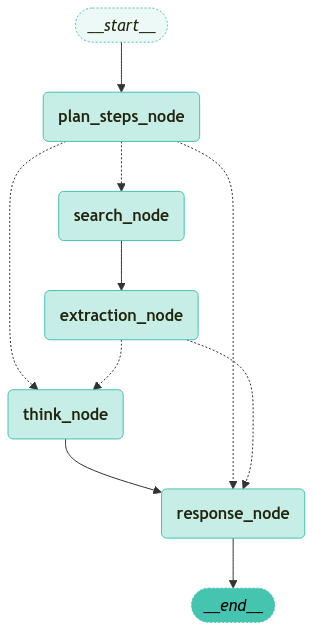

In [16]:
from langchain_opentutorial.graphs import visualize_graph

visualize_graph(graph)

## Run Workflow

This section details the execution phase of the workflow.

It explains how the entire system is run from start to finish using asynchronous execution, which enables real-time monitoring and interaction.

### Streaming Graph Execution

The **streaming graph execution** part describes how the workflow graph is run asynchronously.

It captures and streams the results in real time, providing immediate feedback on each node's output.

This approach is especially useful for long-running tasks, as it keeps the user informed of the system’s progress.

In [17]:
import asyncio
from typing import Any, Dict, List, Callable
from langchain_core.runnables import RunnableConfig
from langgraph.graph.state import CompiledStateGraph


async def astream_graph(
    graph: CompiledStateGraph,
    inputs: Dict[str, Any],
    config: RunnableConfig,
    node_names: List[str] = [],
    callback: Callable[[Dict[str, str]], None] = None,
):
    """
    LangGraph의 실행 결과를 비동기 방식으로 스트리밍하여 출력하는 함수입니다.

    매개변수:
    - graph (CompiledStateGraph): 실행할 컴파일된 LangGraph 객체
    - inputs (dict): 그래프에 전달할 입력값 딕셔너리
    - config (RunnableConfig): 실행 설정
    - node_names (List[str], optional): 출력할 노드 이름 목록 (빈 리스트면 모든 노드 출력)
    - callback (Callable[[Dict[str, str]], None], optional): 각 청크 처리를 위한 콜백 함수 (기본값: None)
      콜백 함수는 {"node": str, "content": str} 형태의 딕셔너리를 인자로 받습니다.

    반환값:
    - None: 함수는 스트리밍 결과를 출력만 하고 반환값은 없습니다.
    """
    prev_node = ""
    async for chunk_msg, metadata in graph.astream(
        inputs, config, stream_mode="messages"
    ):
        curr_node = metadata["langgraph_node"]

        # node_names가 비어있거나 현재 노드가 node_names에 포함된 경우에만 처리
        if not node_names or curr_node in node_names:
            if callback:
                callback({"node": curr_node, "content": chunk_msg.content})
            else:
                # 노드가 변경될 때마다 헤더를 출력
                if curr_node != prev_node:
                    print("\n" + "=" * 60)
                    print(f"🔄 Node: \033[1;36m{curr_node}\033[0m 🔄")
                    print("=" * 60)

                # 쿼리 정보가 있으면 출력
                tool_calls = chunk_msg.additional_kwargs.get("tool_calls", [])
                if tool_calls:
                    # print(f"🔍 Query: ", end="")
                    for tool_call in tool_calls:
                        query = tool_call.get("function", {}).get("arguments", "")
                        if query:

                            print(f"{query}", end="", flush=True)
                else:
                    # 쿼리 정보가 없으면 content 출력
                    content = chunk_msg.content
                    if content:
                        print(content, end="", flush=True)

            prev_node = curr_node

### Configure and Run Workflow Graph

Before running the workflow, configuration parameters and input data are set up in this section.

It outlines the process of initializing the graph with these settings and executing it with a sample query.

This step-by-step setup demonstrates how the system processes information from planning to final answer generation.

In [18]:
# Configuration
config = {
    "configurable": {
        "thread_id": 11,  # temporary thread ID for testing
    },
}

inputs = AgentState(
    messages=[
        HumanMessage(
            content="How did the implementation of artificial intelligence in supply chain management during the COVID-19 pandemic impact global trade efficiency, and what are the current trends and future projections for AI-driven supply chains in the next decade?"
        )
    ],
    steps=[],
    answer=None,
)

In [19]:
# Execute the graph asynchronously
await astream_graph(graph, inputs, config=config)


🔄 Node: plan_steps_node 🔄
{"steps":[{"id":"1","description":"Search for information on the impact of AI in supply chain management during the COVID-19 pandemic on global trade efficiency.","status":"pending","type":"search","search_result":null,"result":null},{"id":"2","description":"Search for current trends in AI-driven supply chains.","status":"pending","type":"search","search_result":null,"result":null},{"id":"3","description":"Search for future projections for AI-driven supply chains in the next decade.","status":"pending","type":"search","search_result":null,"result":null},{"id":"4","description":"Analyze the collected data to assess the impact, current trends, and future projections of AI in supply chain management.","status":"pending","type":"think","search_result":null,"result":null},{"id":"5","description":"Respond with a comprehensive summary of the impact of AI on supply chain management during COVID-19, current trends, and future projections.","status":"pending","type":"r

### Examine Final State and Display Answer

Finally, this section explains how to retrieve and display the final results of the workflow.

It shows how to access the final state, render the answer in markdown, and print the references.

This final step ensures that the output is clear, well-formatted, and properly referenced, effectively concluding the end-to-end demonstration of the system.

In [20]:
# Example states
graph.get_state(config).values

{'messages': [HumanMessage(content='How did the implementation of artificial intelligence in supply chain management during the COVID-19 pandemic impact global trade efficiency, and what are the current trends and future projections for AI-driven supply chains in the next decade?', additional_kwargs={}, response_metadata={}, id='29646c75-d959-476d-b6ff-cf232e114ff6')],
 'steps': [TaskStep(id='1', description='Search for information on the impact of AI in supply chain management during the COVID-19 pandemic on global trade efficiency.', status='completed', type='search', data={}, search_result=None, result=None),
  TaskStep(id='2', description='Search for current trends in AI-driven supply chains.', status='completed', type='search', data={}, search_result=None, result=None),
  TaskStep(id='3', description='Search for future projections for AI-driven supply chains in the next decade.', status='completed', type='search', data={}, search_result=None, result=None),
  TaskStep(id='4', descr

In [21]:
from IPython.display import Markdown

# Examine the final markdown answer
Markdown(graph.get_state(config).values["answer"].markdown)

## Impact of AI on Supply Chain Management During COVID-19

The implementation of artificial intelligence (AI) in supply chain management during the COVID-19 pandemic significantly improved global trade efficiency by addressing disruptions and enhancing resilience. AI technologies enabled better demand forecasting, inventory management, and logistics optimization, which were crucial as supply chains faced unprecedented challenges. For instance, AI-driven analytics allowed companies to predict demand surges and adjust their supply strategies accordingly, minimizing delays and shortages[1]. Moreover, AI facilitated real-time tracking and visibility across the supply chain, helping businesses to quickly adapt to changing conditions and maintain operational continuity[2].

## Current Trends in AI-Driven Supply Chains

Currently, AI in supply chains is focused on increasing automation, enhancing decision-making, and improving sustainability. Automation through AI-driven robotics and machine learning algorithms is streamlining operations by reducing human error and increasing speed and accuracy. Decision-making is being enhanced through advanced data analytics, which provide insights that help businesses respond swiftly to market changes. Additionally, AI is playing a pivotal role in driving sustainability by optimizing resource use and reducing waste[3].

## Future Projections for AI-Driven Supply Chains

Looking ahead, AI is expected to transform supply chains over the next decade by further integrating advanced technologies such as the Internet of Things (IoT) and blockchain for greater transparency and efficiency. AI-driven supply chains will likely become more autonomous, with increased use of predictive analytics and machine learning to anticipate disruptions and optimize operations proactively. Furthermore, as AI technologies continue to evolve, they are expected to contribute to more sustainable practices, helping companies meet environmental goals and comply with regulations[4].

[1]: [How AI Helped Supply Chains During COVID-19](https://www.example.com/ai-supply-chain-covid)
[2]: [The Role of AI in Supply Chain Management](https://www.example.com/role-of-ai-supply-chain)
[3]: [Current Trends in AI-Driven Supply Chains](https://www.example.com/ai-supply-chain-trends)
[4]: [Future of AI in Supply Chains](https://www.example.com/ai-supply-chain-future)

In [22]:
# Examine references
pprint(graph.get_state(config).values["answer"].references)

[Reference(citation_id=1, title='How AI Helped Supply Chains During COVID-19', url='https://www.example.com/ai-supply-chain-covid'),
 Reference(citation_id=2, title='The Role of AI in Supply Chain Management', url='https://www.example.com/role-of-ai-supply-chain'),
 Reference(citation_id=3, title='Current Trends in AI-Driven Supply Chains', url='https://www.example.com/ai-supply-chain-trends'),
 Reference(citation_id=4, title='Future of AI in Supply Chains', url='https://www.example.com/ai-supply-chain-future')]
